In [2]:
from Game import *
from Game.minimax import *

Version:  0.3.02


# Connect 3

In [5]:
def initial_state():
    return Board(4,5)

def valid_moves(state,player):
    moves=[]

    for i in range(5):
        if state[i]==0:
            moves.append(i)

    return moves

def show_state(state,player):
    print(state)

def update_state(state,player,move):
    if isinstance(move,int):
        new_state=state

        i=move+15

        while new_state[i]!=0:
            i-=5

        new_state[i]=player

    return new_state

def win_status(state,player):
    # 0  1  2  3  4 
    # 5  6  7  8  9 
    # 10 11 12 13 14 
    # 15 16 17 18 19

    if player==1:
        other_player=2

    else:
        other_player=1

    for row in state.rows(3):
        if row==[player,player,player]:
            return "win"
            
    for col in state.cols(3):
        if col==[player,player,player]:
            return "win"

    for diag in state.diags(3):
        if diag==[player,player,player]:
            return "win"

    if not valid_moves(state,other_player):
        return "stalemate"

    return None

## Agents

In [8]:
def random_move(state,player):
    moves=valid_moves(state,player)
    return random.choice(moves)

random_agent=Agent(random_move)

def human_move(state,player):
    while True:
        move = int(input("What is your move? "))

        if move not in valid_moves(state,player):
            print("Illegal move.")
        else:
            break
        
    return move

human_agent=Agent(human_move) 

In [10]:
def minimax_move(state,player):
    values,actions=minimax_values(state,player,maxdepth=5,display=False)
    return top_choice(actions,values)
minimax_agent=Agent(minimax_move)

In [12]:
def first_move_heuristic(state,player):
    if state[17]==0:
        move=2
        return move
    else:
        moves=valid_moves(state,player)
        return random.choice(moves)

smarter_agent=Agent(first_move_heuristic)

### Skittles Agent

In [15]:
def skittles_move(state,player,info):
    S=info.S
    last_state=info.last_state
    last_action=info.last_action
    verbose=info.verbose

    
    if verbose:
        print("\t","Player ",player," is thinking...")
        print("\t","State: ",state)
        print("\t","Table:",S)
        print("\t","Last state,action: ",last_state,last_action)
    
    # make/adjust the table

    if state not in S:
        # add a row to the table for each move
        S[state]=Table()
        moves=valid_moves(state,player)
        for action in moves:
            S[state][action]=3  # number of skittles/beads for each move
    
        if verbose:
            print("\t","State ",state,"unknown...added to table")
            print("\t","Table",S)
    
    move=weighted_choice(S[state])
    if verbose:
        print("\t","Choosing from S[",state,"]",S[state],"....Move: ",move)

    if move is None:  # there are no skittles in this row
        if last_state:
            if verbose:
                print("\t","No possible moves!")
                print("\t","Modifying the table: removing one skittle from (state,action) ",last_state,last_action)
            S[last_state][last_action]=S[last_state][last_action]-1
            
            if verbose:
                print("\t","Table:",S)
                
            if S[last_state][last_action]<0:                
                S[last_state][last_action]=0
                if verbose:
                    print("\t","Negative skittles...fixing.")
                    print("\t","Table:",S)                
        else:
            if verbose:
                print("\t","Started in a bad state ",state,"with no moves and no last state.  Won't modify table.")
                  
                  

        move=random_move(state,player)

    
    return move

def skittles_after(status,player,info):
    S=info.S
    last_state=info.last_state
    last_action=info.last_action
    verbose=info.verbose

    if verbose:
        print("\t","End of Game adjustments")
        print("\t","Player ",player," is thinking...")
        print("\t","Win Status: ",status)
        print("\t","Table:",S)
        print("\t","Last state,action: ",last_state,last_action)
        
    if status=='lose':
        if last_state:
            S[last_state][last_action]=S[last_state][last_action]-1
            if S[last_state][last_action]<0:
                S[last_state][last_action]=0
                
            if verbose:
                print("\t","Modifying the table: removing one skittle from (state,action) ",last_state,last_action)
                print("\t","Table:",S)

                
        else:
            if verbose:
                print("\t","No last state, so nothing to learn.")
            
                
    else:
        if verbose:
            print("\t","No adjustments needed.")
        
    # does this double-count the learning if you lose on your own turn

In [17]:
skittles_agent1=Agent(skittles_move)
skittles_agent1.S=Table()
skittles_agent1.post=skittles_after
skittles_agent1.verbose=False

skittles_agent2=Agent(skittles_move)
skittles_agent2.S=Table()
skittles_agent2.post=skittles_after
skittles_agent2.verbose=False

In [19]:
%matplotlib inline
from matplotlib.pyplot import figure,plot,grid,legend,xlabel,ylabel,title
from tqdm import tqdm

In [20]:
agent1=skittles_agent1
agent1.S=Table()

agent2=skittles_agent2
agent2.S=Table()

In [23]:
S=Storage()
one,two,ties,N=0,0,0,0

In [24]:
for i in tqdm(range(50000)):
    g=Game(number_of_games=100)
    g.display=False
    
    result=g.run(agent1,agent2)
    one,two,ties,N=one+result.count(1),two+result.count(2),ties+result.count(0),N+len(result)
    
    S+=one/N*100,two/N*100,ties/N*100,N
    
y1,y2,y0,x=S.arrays()

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [8:20:25<00:00,  1.67it/s]


Text(0, 0.5, 'Percent')

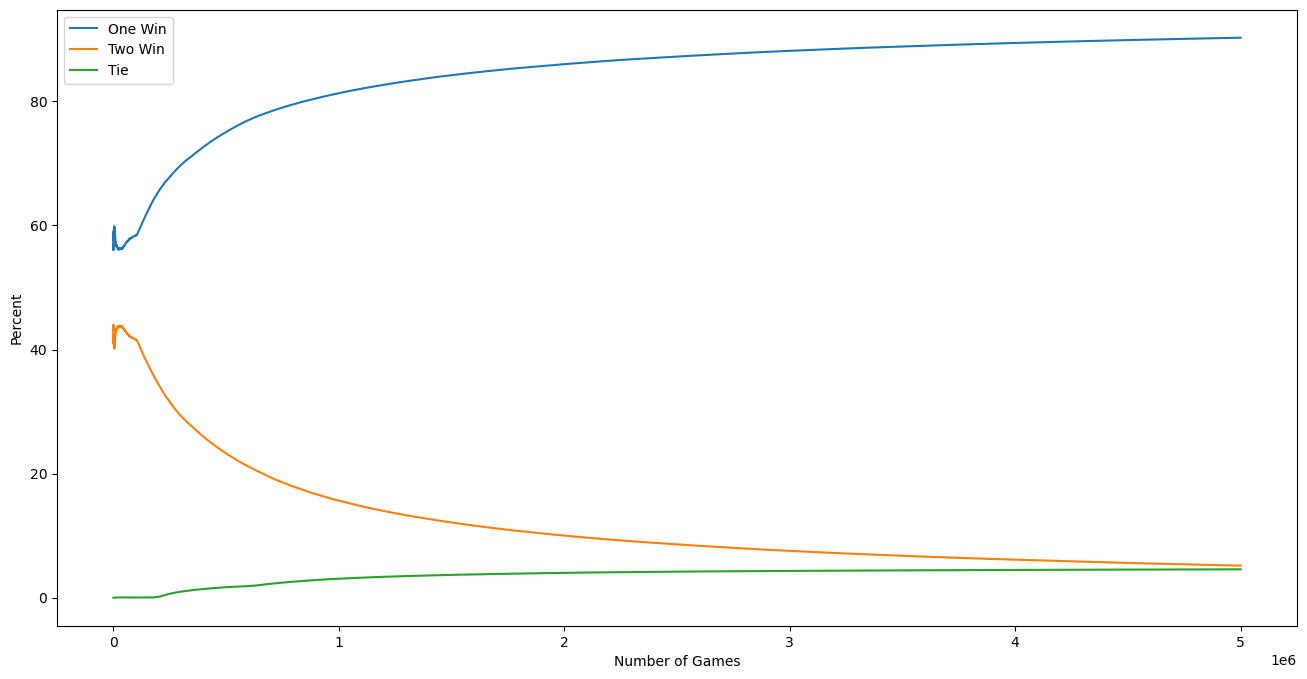

In [27]:
figure(figsize=(16,8))
plot(x,y1,label='One Win')
plot(x,y2,label='Two Win')
plot(x,y0,label='Tie')
legend()
xlabel('Number of Games')
ylabel('Percent')

In [29]:
SaveTable(skittles_agent1.S,'connect3 skittles1.json')
SaveTable(skittles_agent2.S,'connect3 skittles2.json')

### Q-Agent

In [26]:
def Q_move(state,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ
    
    if state not in Q:
        actions=valid_moves(state,player)
        Q[state]=Table()
        for action in actions:
            Q[state][action]=0  # initial value of table
    
    if learning:
        if random.random()<ϵ:  # take a random move occasionally to explore the environment
            move=random_move(state,player)
        else:
            move=top_choice(Q[state])
    else:
        move=top_choice(Q[state])
    
    if not last_action is None:  # not the first move
        reward=0
        
        # learn
        if learning:
            Q[last_state][last_action]+=α*(reward +
                        γ*max([Q[state][a] for a in Q[state]]) - Q[last_state][last_action])
    
    return move

In [28]:
def Q_after(status,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ

    if status=='lose':
        reward=-1
    elif status=='win':
        reward=1
    elif status=='stalemate':
        reward=.5 # value stalemate a little closer to a win
    else:
        reward=0
    
    
    if learning:
        Q[last_state][last_action]+=α*(reward - Q[last_state][last_action])

In [30]:
Q1_agent=Agent(Q_move)
Q1_agent.post=Q_after
Q1_agent.Q=Table()  # makes an empty table
Q1_agent.learning=True

Q1_agent.α=0.8  # learning rate
Q1_agent.ϵ=0.5  # how often to take a random move
Q1_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

In [32]:
Q2_agent=Agent(Q_move)
Q2_agent.post=Q_after
Q2_agent.Q=Table()  # makes an empty table
Q2_agent.learning=True

Q2_agent.α=0.8  # learning rate
Q2_agent.ϵ=0.5  # how often to take a random move
Q2_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

In [34]:
agent1=Q1_agent
agent1.Q=Table()
agent2=Q2_agent
agent2.Q=Table()

In [36]:
S=Storage()
one,two,ties,N=0,0,0,0

In [38]:
N_test=100
N_train=100

In [40]:
for i in tqdm(range(2000)):
    Q1_agent.learning=True
    Q2_agent.learning=True
    g=Game(number_of_games=N_train)
    g.display=False
    result=g.run(agent1,agent2)

    
    Q1_agent.learning=False
    Q2_agent.learning=False
    g=Game(number_of_games=N_test)
    g.display=False
    result=g.run(agent1,agent2)
    one,two,ties,N=one+result.count(1),two+result.count(2),ties+result.count(0),N+len(result)
    
    S+=one/N*100,two/N*100,ties/N*100,N

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [39:34<00:00,  1.19s/it]


In [42]:
y1,y2,y0,x=S.arrays()

Text(0, 0.5, 'Percent')

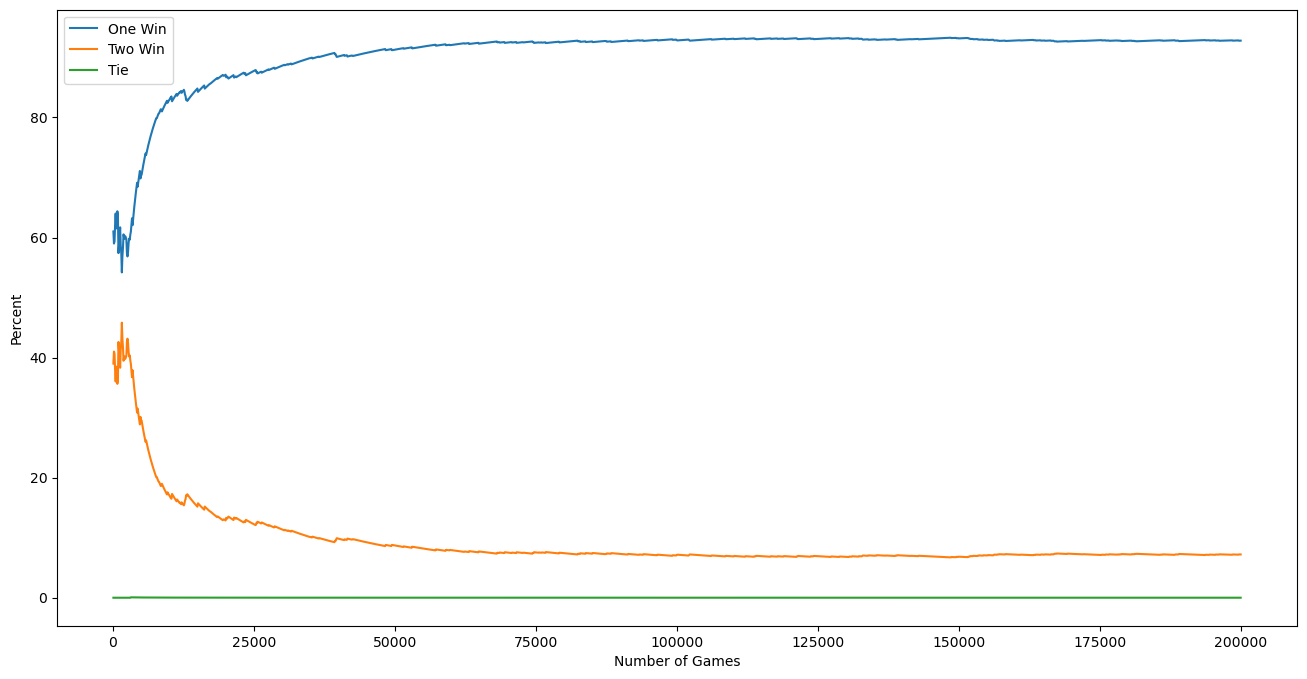

In [44]:
figure(figsize=(16,8))
plot(x,y1,label='One Win')
plot(x,y2,label='Two Win')
plot(x,y0,label='Tie')
legend()
xlabel('Number of Games')
ylabel('Percent')

In [46]:
SaveTable(Q1_agent.Q,"Connect3 Q1.json")
SaveTable(Q2_agent.Q,"Connect3 Q2.json")

## Testing

In [107]:
Q1_agent.learning=False
Q2_agent.learning=False

In [109]:
g=Game(number_of_games=1000)
g.display=False
g.run(minimax_agent,Q2_agent)
g.report()

Total number of games:  1000
Winning 45.40 percent
Losing 54.60 percent
Tie 0.00 percent


In [111]:
g=Game(number_of_games=1000)
g.display=False
result=g.run(random_agent,minimax_agent)
g.report()

Total number of games:  1000
Winning 22.30 percent
Losing 77.70 percent
Tie 0.00 percent


In [115]:
g=Game(number_of_games=1000)
g.display=False
result=g.run(random_agent,Q2_agent)
g.report()

Total number of games:  1000
Winning 5.70 percent
Losing 94.30 percent
Tie 0.00 percent


In [117]:
g=Game(number_of_games=1000)
g.display=False
result=g.run(random_agent,random_agent)
g.report()

Total number of games:  1000
Winning 59.40 percent
Losing 40.60 percent
Tie 0.00 percent
